# Federated learning: Simulation of data poisoning attack

In this notebook provide a simulation of a simple data poisoning federated attack. We use a simple first approach 
which consists on shuffling the training labels of some number of clients which become adversarial ones.

The aim of this notebook is to present the class FederatedDataAttack implemented in [federated_attack.py](https://github.com/sherpaai/Sherpa.FL/blob/master/shfl/private/federated_attack.py) whose goal is to 
implement any attack on the federated data. For more information about basic federated learning concepts refers to [Basic Concepts Notebook](https://github.com/sherpaai/Sherpa.FL/blob/master/notebooks/basic_concepts.ipynb).

For the simulation we use [Emnist](https://www.nist.gov/itl/products-and-services/emnist-dataset) Digits dataset.

In [1]:
import shfl
import numpy as np
import random

database = shfl.data_base.Emnist()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/py

After that, we distribute the data among the client nodes using a non-iid distribution over 10\% of the data. 

In [2]:
noniid_distribution = shfl.data_distribution.NonIidDataDistribution(database)
federated_data, test_data, test_labels = noniid_distribution.get_federated_data(num_nodes=20, percent=10)

At this point, we are ready to apply some data attack to some nodes. For this simulation, we choose to apply data 
poisoning to the 20\% of the nodes. For that purpose, we implement the inferface FederatedTransformation with a shuffling of the training labels of federated_data and create FederatedPoisoninigDataAttack, which implements FederatedDataAttack with a data poisoning in a certain percentage of the nodes. The full code is in [link]().

In [3]:
from shfl.private.federated_operation import FederatedTransformation
from shfl.private.federated_attack import FederatedDataAttack

class ShuffleNode(FederatedTransformation):
    def apply(self, labeled_data):
        random.shuffle(labeled_data.label)

class FederatedPoisoningDataAttack(FederatedDataAttack):
    def __init__(self, percentage):
        super().__init__()
        self._percentage = percentage
        self._adversaries = []

    @property
    def adversaries(self):
        return self._adversaries

    def apply_attack(self, federated_data):
        num_nodes = federated_data.num_nodes()
        list_nodes = np.arange(num_nodes)
        self._adversaries = random.sample(list(list_nodes), k=int(self._percentage / 100 * num_nodes))
        boolean_adversaries = [1 if x in self._adversaries else 0 for x in list_nodes]

        for node, boolean in zip(federated_data, boolean_adversaries):
            if boolean:
                node.apply_data_transformation(ShuffleNode())


We create a FederatedPoisoningDataAttack object with percentage = 20\% and apply the attack over federated\_data.

In [4]:
simple_attack = FederatedPoisoningDataAttack(percentage=20)
simple_attack.apply_attack(federated_data = federated_data)

We can get the adversarial nodes in order to show the attack applied.

In [5]:
adversarial_nodes = simple_attack.adversaries
adversarial_nodes

[0, 16, 18, 14]

In order to show the effect of the attack, we select one adversarial client and an index position and show the data and the label associated with this image. We use a federated transformation in order to access the data. We check that the image does not match the selected label. Due to the nature of the data poisoning (random shuffle) it is possible that for some specific data the label does match, but in most cases it does not.

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


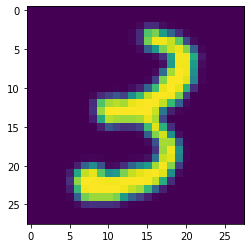

In [6]:
import matplotlib.pyplot as plt

adversarial_index = 0
data_index = 10

adversarial_node = federated_data[adversarial_nodes[adversarial_index]]
class ShowAdversaries(FederatedTransformation):

    def apply(self, labeled_data):
        plt.imshow(labeled_data.data[data_index])
        print(labeled_data.label[data_index])
        
adversarial_node.apply_data_transformation(ShowAdversaries())

At this point, we can train a FL model among these clients (adversarial and regular ones) using a specific aggregation operator. For more information please see [Basic Concepts Notebook](https://github.com/sherpaai/Sherpa.FL/blob/master/notebooks/basic_concepts.ipynb).